# Waymo Open Dataset Motion Tutorial

- Website: https://waymo.com/open
- GitHub: https://github.com/waymo-research/waymo-open-dataset

This tutorial demonstrates:
- How to decode and interpret the data.
- How to train a simple model with Tensorflow.

Visit the [Waymo Open Dataset Website](https://waymo.com/open) to download the full dataset.

To use, open this notebook in [Colab](https://colab.research.google.com).

Uncheck the box "Reset all runtimes before running" if you run this colab directly from the remote kernel. Alternatively, you can make a copy before trying to run it by following "File > Save copy in Drive ...".

/home/robot/miniconda3/bin/python


# Package installation

Please follow the instructions in [tutorial.ipynb](https://github.com/waymo-research/waymo-open-dataset/blob/master/tutorial/tutorial.ipynb).

# Imports and global definitions

In [1]:
# Data location. Please edit.

# A tfrecord containing tf.Example protos as downloaded from the Waymo dataset
# webpage.

# Replace this path with your own tfrecords.
FILENAME = '/media/robot/hdd/waymo_dataset/tf_example/training/training_tfexample.tfrecord-00000-of-01000'

DATASET_FOLDER = '/path/to/waymo_open_dataset_motion_v_1_1_0/uncompressed'

In [2]:
import math
import os
import uuid
import time

from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.pyplot as plt

import numpy as np
from IPython.display import HTML
import itertools
import tensorflow as tf

from google.protobuf import text_format
from waymo_open_dataset.metrics.ops import py_metrics_ops
from waymo_open_dataset.metrics.python import config_util_py as config_util
from waymo_open_dataset.protos import motion_metrics_pb2

# Example field definition
roadgraph_features = {
    'roadgraph_samples/dir':
        tf.io.FixedLenFeature([20000, 3], tf.float32, default_value=None),
    'roadgraph_samples/id':
        tf.io.FixedLenFeature([20000, 1], tf.int64, default_value=None),
    'roadgraph_samples/type':
        tf.io.FixedLenFeature([20000, 1], tf.int64, default_value=None),
    'roadgraph_samples/valid':
        tf.io.FixedLenFeature([20000, 1], tf.int64, default_value=None),
    'roadgraph_samples/xyz':
        tf.io.FixedLenFeature([20000, 3], tf.float32, default_value=None),
}

# Features of other agents.
state_features = {
    'state/id':
        tf.io.FixedLenFeature([128], tf.float32, default_value=None),
    'state/type':
        tf.io.FixedLenFeature([128], tf.float32, default_value=None),
    'state/is_sdc':
        tf.io.FixedLenFeature([128], tf.int64, default_value=None),
    'state/tracks_to_predict':
        tf.io.FixedLenFeature([128], tf.int64, default_value=None),
    'state/current/bbox_yaw':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/height':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/length':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/timestamp_micros':
        tf.io.FixedLenFeature([128, 1], tf.int64, default_value=None),
    'state/current/valid':
        tf.io.FixedLenFeature([128, 1], tf.int64, default_value=None),
    'state/current/vel_yaw':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/velocity_x':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/velocity_y':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/width':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/x':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/y':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/z':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/future/bbox_yaw':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/height':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/length':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/timestamp_micros':
        tf.io.FixedLenFeature([128, 80], tf.int64, default_value=None),
    'state/future/valid':
        tf.io.FixedLenFeature([128, 80], tf.int64, default_value=None),
    'state/future/vel_yaw':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/velocity_x':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/velocity_y':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/width':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/x':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/y':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/z':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/past/bbox_yaw':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/height':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/length':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/timestamp_micros':
        tf.io.FixedLenFeature([128, 10], tf.int64, default_value=None),
    'state/past/valid':
        tf.io.FixedLenFeature([128, 10], tf.int64, default_value=None),
    'state/past/vel_yaw':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/velocity_x':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/velocity_y':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/width':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/x':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/y':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/z':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
}

traffic_light_features = {
    'traffic_light_state/current/state':
        tf.io.FixedLenFeature([1, 16], tf.int64, default_value=None),
    'traffic_light_state/current/valid':
        tf.io.FixedLenFeature([1, 16], tf.int64, default_value=None),
    'traffic_light_state/current/x':
        tf.io.FixedLenFeature([1, 16], tf.float32, default_value=None),
    'traffic_light_state/current/y':
        tf.io.FixedLenFeature([1, 16], tf.float32, default_value=None),
    'traffic_light_state/current/z':
        tf.io.FixedLenFeature([1, 16], tf.float32, default_value=None),
    'traffic_light_state/past/state':
        tf.io.FixedLenFeature([10, 16], tf.int64, default_value=None),
    'traffic_light_state/past/valid':
        tf.io.FixedLenFeature([10, 16], tf.int64, default_value=None),
    'traffic_light_state/past/x':
        tf.io.FixedLenFeature([10, 16], tf.float32, default_value=None),
    'traffic_light_state/past/y':
        tf.io.FixedLenFeature([10, 16], tf.float32, default_value=None),
    'traffic_light_state/past/z':
        tf.io.FixedLenFeature([10, 16], tf.float32, default_value=None),
}

features_description = {}
features_description.update(roadgraph_features)
features_description.update(state_features)
features_description.update(traffic_light_features)

# Visualize TF Example sample

## Create Dataset.

In [3]:
dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')

In [4]:
data = next(dataset.as_numpy_iterator())
parsed = tf.io.parse_single_example(data, features_description)

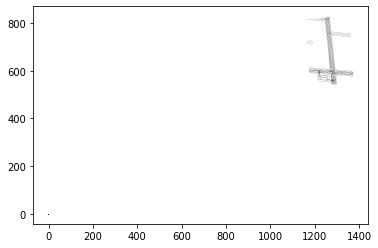

In [5]:
img = parsed["roadgraph_samples/xyz"].numpy() #.reshape(100,200,3)
# plt.imshow(img/img.max())

rg_pts = img[:, :2].T

plt.plot(rg_pts[0, 300:], rg_pts[1, 300:], 'k.', alpha=1, ms=0.01)


In [6]:
parsed["state/future/valid"].numpy()[:20,::10]

array([[1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0]])

In [7]:
# print(np.unique(parsed["roadgraph_samples/id"].numpy().reshape(-1)))
# print()
# print(parsed['roadgraph_samples/type'])



# (parsed['roadgraph_samples/xyz'].numpy()[:,0] > -1).sum()


In [8]:
print(parsed["state/current/x"].numpy()[parsed["state/current/valid"].numpy()>0].shape)
print(parsed["state/current/x"].numpy()[parsed["state/tracks_to_predict"].numpy()>0].shape)
print(parsed["state/future/x"].numpy()[parsed["state/future/valid"].numpy()>0].shape)
# print(parsed["state/current/valid"].numpy())
(parsed["state/past/x"].numpy()).shape

(61,)
(6, 1)
(4847,)


(128, 10)

# Torch dataset

In [9]:
import torch
from tfrecord.torch.dataset import TFRecordDataset
from tqdm import tqdm

In [10]:
context_description = {
                         'roadgraph_samples/xyz': "float",
                         "state/current/x": 'float',
                         "state/current/y": 'float',
                         "state/past/x": 'float',
                         "state/past/y": 'float',
                         "state/future/x": 'float',
                         "state/future/y": 'float',
                         "state/future/valid": 'int',
                         "state/current/valid": "int",
                         "state/past/valid": "int",
                         "state/tracks_to_predict": "int",
                     }

In [11]:
tbs = {}
PAD_WIDTH = 20000
dataset = TFRecordDataset(FILENAME,
                          index_path=None, 
                          description=context_description, 
#                           infinite=False
                         )

loader = torch.utils.data.DataLoader(dataset, batch_size=64)
data = next(iter(loader))

In [12]:
iterator = iter(dataset)

In [13]:
iterator = iter(loader)

for i in tqdm(range(100000)):
    try:
        data = next(iterator)
        list(data.keys())
    except StopIteration:
        break
    break

  0%|          | 0/100000 [00:01<?, ?it/s]


In [14]:
# FILENAME

In [15]:
import glob
files = glob.glob("/media/robot/hdd/waymo_dataset/tf_example/training/training_tfexample.*-of-01000")

In [16]:
from itertools import chain
class CustomImageDataset(torch.utils.data.IterableDataset):
    def __init__(self, tf_dir, context_desription, transform=None, target_transform=None):
        self.tf_dir = tf_dir
        self.context_desription = context_desription
        self.tf_files = glob.glob("/media/robot/hdd/waymo_dataset/tf_example/training/training_tfexample.*-of-01000")
        self.transform = transform
        self.target_transform = target_transform
        self.cur_file_index = 0
        self.dataset = TFRecordDataset(self.tf_files[0], index_path=None, description=self.context_desription) 
        self.iterator = iter(self.dataset)

    def __iter__(self):
        for file in self.tf_files[1:]:
                dataset = TFRecordDataset(file, index_path=None, description=self.context_desription)
                self.iterator = chain(self.iterator, iter(dataset))
                
        return self.iterator
#         except StopIteration:
#             self.__next_file()
#             data = next(self.iterator)
            
#         return data

    def __next_file(self):
        if (self.cur_file_index + 1 < len(self.tf_files)):
            self.cur_file_index += 1
            self.dataset = TFRecordDataset(self.tf_files[self.cur_file_index],
                          index_path=None, 
                          description=self.context_desription)
            self.iterator = iter(self.dataset)
            return
        raise StopIteration

In [17]:
tfrecord_patth = "/media/robot/hdd/waymo_dataset/tf_example/training/"
dataset = CustomImageDataset(tfrecord_patth, context_description)
loader = torch.utils.data.DataLoader(dataset, batch_size=4)

In [18]:
iterator = iter(loader)
for i in tqdm(range(1000)):
    data = next(iterator)
    data["roadgraph_samples/xyz"]
    break


  0%|          | 0/1000 [00:00<?, ?it/s]


In [19]:
for key in data.keys():
    print(key, data[key].shape)

roadgraph_samples/xyz torch.Size([4, 60000])
state/current/x torch.Size([4, 128])
state/current/y torch.Size([4, 128])
state/past/x torch.Size([4, 1280])
state/past/y torch.Size([4, 1280])
state/future/x torch.Size([4, 10240])
state/future/y torch.Size([4, 10240])
state/future/valid torch.Size([4, 10240])
state/current/valid torch.Size([4, 128])
state/past/valid torch.Size([4, 1280])
state/tracks_to_predict torch.Size([4, 128])


In [20]:
cur = torch.cat([data["state/current/x"].reshape(-1,1,128,1), data["state/current/y"].reshape(-1,1,128,1)], -1)
past = torch.cat([data["state/past/x"].reshape(-1,10,128,1), data["state/past/y"].reshape(-1,10,128,1)], -1)

state = torch.cat([cur, past], 1).permute(0,2,1,3) #.reshape(-1,11,128*2)
state.shape

torch.Size([4, 128, 11, 2])

In [21]:
import torch.nn as nn


In [40]:
class SimplModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.dec = nn.Sequential(nn.Linear(22, 64),
                                 nn.ReLU(),
                                 nn.Linear(64,160))
        
    def forward(self, data):
        bs = data["roadgraph_samples/xyz"].shape[0]
#         src = self.lin_xyz(data["roadgraph_samples/xyz"].reshape(bs,-1,3).cuda()).reshape(bs,-1,500)
#         tgt = torch.rand(bs, 128, 500).cuda()
#         out_0 = self.tr(src.permute(1,0,2), tgt.permute(1,0,2)).permute(1,0,2)
#         out_0 = self.lin_xyz_post(out_0)
        cur = torch.cat([data["state/current/x"].reshape(-1,1,128,1), data["state/current/y"].reshape(-1,1,128,1)], -1)
        past = torch.cat([data["state/past/x"].reshape(-1,128,10,1), data["state/past/y"].reshape(-1,128,10,1)], -1).permute(0,2,1,3)
        state = torch.cat([cur, past], 1).permute(0,2,1,3).reshape(-1,128,11*2).cuda()
        out = self.dec(state).reshape(-1,128,80,2)
        return out
    

In [22]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.tr = nn.Transformer(d_model=500, nhead=4, num_encoder_layers=4) #.cuda()
        self.lin_xyz = nn.Linear(3,2) #.cuda()
        self.lin_xyz_post = nn.Linear(500,64)
        self.hist_tr = nn.Transformer(d_model=24, nhead=4, num_encoder_layers=4) #.cuda()
        self.lin_hist = nn.Linear(22,24) #.cuda()
        
        self.future_tr = nn.Transformer(d_model=160, nhead=4, num_encoder_layers=4) #.cuda()
        self.lin_fut = nn.Linear(88,160)
#         self.dec = nn.Sequential(nn.Linear(20+160, ))
        self.dec = nn.Sequential(nn.Linear((20+160), 160),
                                 nn.ReLU(),
                                 nn.Linear(160,160))
        
    def forward(self, data):
        bs = data["roadgraph_samples/xyz"].shape[0]
        src = self.lin_xyz(data["roadgraph_samples/xyz"].reshape(bs,-1,3).cuda()).reshape(bs,-1,500)
        tgt = torch.rand(bs, 128, 500).cuda()
        out_0 = self.tr(src.permute(1,0,2), tgt.permute(1,0,2)).permute(1,0,2)
        out_0 = self.lin_xyz_post(out_0)
        cur = torch.cat([data["state/current/x"].reshape(-1,1,128,1), data["state/current/y"].reshape(-1,1,128,1)], -1)
        past = torch.cat([data["state/past/x"].reshape(-1,128,10,1), data["state/past/y"].reshape(-1,128,10,1)], -1).permute(0,2,1,3)
        state = torch.cat([cur, past], 1).permute(0,2,1,3).reshape(-1,128,11*2).cuda()
        state = self.lin_hist(state)
        tgt = torch.rand(bs, 128, 24).cuda()
        out_1 = self.hist_tr(state.permute(1,0,2), tgt.permute(1,0,2)).permute(1,0,2)
        out_2 = self.lin_fut(torch.cat([out_0, out_1], -1))
        future_tgt = cur.reshape(-1,1,128,2).repeat(1,80,1,1).permute(0,2,1,3).reshape(-1,128,160).cuda()
        out_3 = self.future_tr(out_2.permute(1, 0, 2), future_tgt.permute(1, 0, 2))
        out_3 = out_3.permute(1,0,2).reshape(-1, 128, 80*2) # bs, 128, 80 ,2
        
        fin_input = torch.cat([past.permute(0,2,1,3).reshape(-1, 128, 20).cuda(),  out_3],-1)
        out = self.dec(fin_input).reshape(-1,128,80,2)
        return out
    
    def get_gt(self, data):
        gt_fut = torch.cat([data["state/future/x"].reshape(bs,128,80,1),data["state/future/y"].reshape(bs,128,80,1)], -1)
        return gt_fut
    
    def get_mask(self, data):
        mask = data["state/tracks_to_predict"]
        return mask
        
        
    def get_n_params(self ):
        pp=0
        for p in list(self.parameters()):
            nn=1
            for s in list(p.size()):
                nn = nn*s
            pp += nn
        return pp

In [23]:
# print(data["state/future/valid"].reshape(4, 128, -1)[0, 10:40, ::10])
# print(data["state/tracks_to_predict"].shape)


In [24]:
torch.cumsum(torch.cat([torch.ones(5).reshape(1,5), 2*torch.ones(5).reshape(1,5)]),1)

tensor([[ 1.,  2.,  3.,  4.,  5.],
        [ 2.,  4.,  6.,  8., 10.]])

In [25]:
def get_future(data):
    bs = data["state/future/x"].shape[0]
    gt_fut = torch.cat([data["state/future/x"].reshape(bs,128,80,1),data["state/future/y"].reshape(bs,128,80,1)], -1)
    gt_fut = gt_fut.permute(0, 2, 1, 3)
    # bs, 80, 128, 2
    return gt_fut 

def get_current(data):
    
    cur = torch.cat([data["state/current/x"].reshape(-1,1, 128,1), data["state/current/y"].reshape(-1, 1, 128, 1)], -1)
    return cur

def get_future_speed(data, num_ped=128, future_steps=80):
    bs = data["state/future/x"].shape[0]
    gt_fut = get_future(data)
    assert gt_fut.shape == torch.Size([bs, future_steps, num_ped , 2])
    cur = get_current(data)
    assert cur.shape == torch.Size([bs, 1, num_ped, 2])
    gt_fut[:,1:,:,:] = gt_fut[:,1:,:,:] - gt_fut[:,:-1,:,:] 
    gt_fut[:,0:1] = gt_fut[:,0:1] - cur
    return gt_fut

def get_valid_data_mask(data):
    bs = data["state/future/x"].shape[0]
    fut_valid = data["state/future/valid"].reshape(bs, 128, -1) * (data["state/current/valid"].reshape(bs, 128, -1)>0)
    fut_valid *= (data["state/past/valid"].reshape(bs,128,10).sum(2) == 10).reshape(bs,128,1)>0
    return fut_valid

def pred_to_future(data, pred, num_ped=128, future_steps=80):
    bs = data["state/future/x"].shape[0]
    pred_poses = pred.clone()
    cur = get_current(data).reshape(-1, 128, 2)
    assert pred.shape == torch.Size([bs, num_ped, future_steps, 2])
    pred_poses[:,:,0] += cur.to(pred.device)
    pred_poses = torch.cumsum(pred_poses,2)
    return pred_poses


def get_ade_fde_with_mask(data, pred, num_ped=128, future_steps=80):
    bs = data["state/future/x"].shape[0]
    assert pred.shape == torch.Size([bs, num_ped, future_steps, 2])
    pred = pred.permute(0,2,1,3) # pred  bs ,80, 128, 2
    gt_fut = get_future(data)
    assert gt_fut.shape == torch.Size([bs, future_steps, num_ped , 2])

    
    cur = get_current(data)
    assert cur.shape == torch.Size([bs, 1, num_ped, 2])
    gt_fut_speed = get_future_speed(data)
    dist = torch.norm(pred - gt_fut_speed.cuda(), dim=3)
    valid = get_valid_data_mask(data)
    mask = data["state/tracks_to_predict"].reshape(-1, 128, 1).repeat(1,1,80) * valid
    mask = mask.permute(0,2,1)
    dist = dist[mask>0]
#     dist = dist[dist<500]
    return dist

def ade_loss(data, pred):
    ade = get_ade_fde_with_mask(data, pred)
    return ade.mean()

In [26]:
# data["state/future/valid"].reshape(8, 128, -1).shape
# data["state/current/valid"].reshape(8, 128, -1).shape

# data["state/future/valid"].reshape(8, 128, -1) * data["state/current/valid"].reshape(8, 128, -1)

In [27]:
torch.tensor([1.]) * (torch.tensor([0])>0)
# out.shape == torch.Size([4, 128, 80 ,2])

tensor([0.])

In [41]:
m = SimplModel().cuda()
out = m(data)

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]),
 array([   63.991123,  1424.3241  ,  2784.6572  ,  4144.99    ,
         5505.323   ,  6865.6562  ,  8225.989   ,  9586.322   ,
        10946.655   , 12306.988   , 13667.321   ], dtype=float32),
 <a list of 2219 BarContainer objects>)

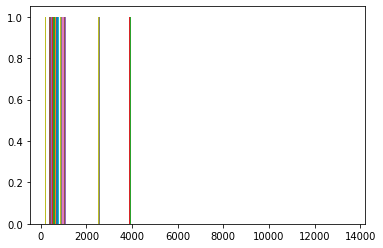

In [42]:
ade = get_ade_fde_with_mask(data, out)
ade.mean()
import matplotlib.pyplot as plt
plt.hist(ade.detach().cpu())

In [43]:
ade.detach().cpu().sort().values[-40:]

tensor([ 4250.9521,  4253.8872,  4255.9443,  4262.0581,  4262.8447,  4274.1558,
         4296.6372,  4307.7539,  4321.7632,  4338.4253,  4344.8677,  4347.1143,
         4353.8564,  4462.5845,  4486.7080,  4490.3682,  4515.5454,  4515.6875,
         4537.9731,  4642.2271,  4698.4907,  4706.3071,  4719.1250,  4729.2075,
         4960.3481,  5141.3994,  5178.6494,  5442.3438,  5477.3892,  5624.4277,
         5643.7407,  5720.9565,  5746.5420,  5875.7549,  5904.7236,  5936.2373,
         5945.8037,  6340.3359,  6375.1128, 13667.3213])

# TORCH TRAINING

In [44]:
batch_size = 8

In [45]:
# torch.cuda.empty_cache()
tfrecord_path = "/media/robot/hdd/waymo_dataset/tf_example/training/"
dataset = CustomImageDataset(tfrecord_path, context_description)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [46]:
import torch.optim as optim
device = "cuda"
net = Model()
criterion = ade_loss

In [47]:
optimizer = optim.Adam(net.parameters(), lr=4e-4)
net = net.to(device)

In [35]:
# overfit test
# with torch.autograd.detect_anomaly():
if 0:
    pbar = tqdm(range(1000))
    for chank in pbar:
        optimizer.zero_grad()
        outputs = net(data)
        loss = ade_loss(data, outputs)
        loss.backward()
        optimizer.step()
        pbar.set_postfix({"loss": loss.detach().item()})

In [48]:
losses = torch.rand(0)

In [49]:
import matplotlib.pyplot as plt

In [50]:
from tqdm.auto import tqdm
from IPython.display import clear_output

from IPython import display
from ipywidgets import Output

In [64]:
char = 12.2
("Processing %s %s" %(char, char))

'Processing 12.2 12.2'

In [66]:
out = Output()
display.display(out)

for epoch in range(2):  # loop over the dataset multiple times
    pbar = tqdm(loader)
    
    for chank, data in enumerate(pbar):
        optimizer.zero_grad()
        outputs = net(data)

        loss = ade_loss(data, outputs)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            speed_ade = get_ade_fde_with_mask(data, outputs)
            losses = torch.cat([losses, torch.tensor([loss.detach().item()])], 0)
            pbar.set_description("ep %s chank %s" % (epoch, chank))
            pbar.set_postfix({"loss": losses.mean().item(), 
                              "median": speed_ade.median().item(),
                              "max": speed_ade.max().item()})
            if len(losses)>500:
                losses = losses[100:]
            if (len(losses)+1) % 30 == 0:
                with out:
                    display.clear_output(wait=True)
                    plt.plot(losses)
                    plt.show()

Output()

KeyboardInterrupt: 

In [67]:
outputs = net(data)
loss = ade_loss(data, outputs )

In [87]:
print(outputs.permute(0,2,1,3).shape)
get_future_speed(data).shape

torch.Size([8, 80, 128, 2])


torch.Size([8, 80, 128, 2])

In [84]:
# print(outputs.shape)
pred_poses = pred_to_future(data, outputs).detach().cpu()
future = get_future_speed(data).permute(0,2,1,3)
print(future.shape)
print(pred_poses.shape)
mask = get_valid_data_mask(data)
# print(mask.shape)
mask = (mask.sum(2)==80)
peds = mask[0].nonzero()[:3,0]

# (outputs.detach().cpu() - future)[0,0,:10]
print()
outputs[0, peds,:4], future[0,peds,:4]

torch.Size([8, 128, 80, 2])
torch.Size([8, 128, 80, 2])



(tensor([[[-1.8643,  3.9377],
          [-5.1703, -4.4496],
          [ 0.2706, -4.8399],
          [ 9.7034, -4.8251]],
 
         [[-2.3043,  4.3989],
          [-5.0480, -4.8048],
          [ 0.3563, -4.0240],
          [ 9.9058, -5.0223]],
 
         [[-2.4792,  4.8220],
          [-4.7494, -4.8479],
          [ 0.4450, -3.4262],
          [ 9.8074, -5.0545]]], device='cuda:0', grad_fn=<IndexBackward>),
 tensor([[[ 9.7656e-04,  1.1887e-02],
          [-9.7656e-04,  1.7548e-02],
          [ 9.7656e-04,  5.4169e-03],
          [ 0.0000e+00,  2.2675e-02]],
 
         [[-9.5703e-02,  1.3412e+00],
          [-1.0156e-01,  1.3593e+00],
          [-9.5703e-02,  1.3046e+00],
          [-9.5703e-02,  1.3279e+00]],
 
         [[ 0.0000e+00,  1.4270e+00],
          [-1.8555e-02,  1.4111e+00],
          [-9.7656e-03,  1.3427e+00],
          [-3.9062e-03,  1.3713e+00]]]))

tensor([0, 1, 5])

In [ ]:
gt = data["state/future/x"].reshape(8, 128, 80)[:,:,1:] - data["state/future/x"].reshape(8, 128, 80)[:,:, :-1]
fut_val = (data["state/future/valid"]>0).reshape(-1,128,80)[:,:,1:]
arr = (outputs[:,:,1:, 0] - gt.cuda())[fut_val>0].detach().cpu().pow(2).sqrt().numpy()
plt.hist(arr, bins=100)

In [89]:
!which python

/home/robot/miniconda3/bin/python


## Generate visualization images.

In [ ]:
def create_figure_and_axes(size_pixels):
  """Initializes a unique figure and axes for plotting."""
  fig, ax = plt.subplots(1, 1, num=uuid.uuid4())

  # Sets output image to pixel resolution.
  dpi = 100
  size_inches = size_pixels / dpi
  fig.set_size_inches([size_inches, size_inches])
  fig.set_dpi(dpi)
  fig.set_facecolor('white')
  ax.set_facecolor('white')
  ax.xaxis.label.set_color('black')
  ax.tick_params(axis='x', colors='black')
  ax.yaxis.label.set_color('black')
  ax.tick_params(axis='y', colors='black')
  fig.set_tight_layout(True)
  ax.grid(False)
  return fig, ax


def fig_canvas_image(fig):
  """Returns a [H, W, 3] uint8 np.array image from fig.canvas.tostring_rgb()."""
  # Just enough margin in the figure to display xticks and yticks.
  fig.subplots_adjust(
      left=0.08, bottom=0.08, right=0.98, top=0.98, wspace=0.0, hspace=0.0)
  fig.canvas.draw()
  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  return data.reshape(fig.canvas.get_width_height()[::-1] + (3,))


def get_colormap(num_agents):
  """Compute a color map array of shape [num_agents, 4]."""
  colors = cm.get_cmap('jet', num_agents)
  colors = colors(range(num_agents))
  np.random.shuffle(colors)
  return colors


def get_viewport(all_states, all_states_mask):
  """Gets the region containing the data.

  Args:
    all_states: states of agents as an array of shape [num_agents, num_steps,
      2].
    all_states_mask: binary mask of shape [num_agents, num_steps] for
      `all_states`.

  Returns:
    center_y: float. y coordinate for center of data.
    center_x: float. x coordinate for center of data.
    width: float. Width of data.
  """
  valid_states = all_states[all_states_mask]
  all_y = valid_states[..., 1]
  all_x = valid_states[..., 0]

  center_y = (np.max(all_y) + np.min(all_y)) / 2
  center_x = (np.max(all_x) + np.min(all_x)) / 2

  range_y = np.ptp(all_y)
  range_x = np.ptp(all_x)

  width = max(range_y, range_x)

  return center_y, center_x, width


def visualize_one_step(states,
                       mask,
                       roadgraph,
                       title,
                       center_y,
                       center_x,
                       width,
                       color_map,
                       size_pixels=1000):
  """Generate visualization for a single step."""

  # Create figure and axes.
  fig, ax = create_figure_and_axes(size_pixels=size_pixels)

  # Plot roadgraph.
  rg_pts = roadgraph[:, :2].T
  ax.plot(rg_pts[0, :], rg_pts[1, :], 'k.', alpha=1, ms=2)

  masked_x = states[:, 0][mask]
  masked_y = states[:, 1][mask]
  colors = color_map[mask]

  # Plot agent current position.
  ax.scatter(
      masked_x,
      masked_y,
      marker='o',
      linewidths=3,
      color=colors,
  )

  # Title.
  ax.set_title(title)

  # Set axes.  Should be at least 10m on a side and cover 160% of agents.
  size = max(10, width * 1.0)
  ax.axis([
      -size / 2 + center_x, size / 2 + center_x, -size / 2 + center_y,
      size / 2 + center_y
  ])
  ax.set_aspect('equal')

  image = fig_canvas_image(fig)
  plt.close(fig)
  return image


def visualize_all_agents_smooth(
    decoded_example,
    size_pixels=1000,
):
  """Visualizes all agent predicted trajectories in a serie of images.

  Args:
    decoded_example: Dictionary containing agent info about all modeled agents.
    size_pixels: The size in pixels of the output image.

  Returns:
    T of [H, W, 3] uint8 np.arrays of the drawn matplotlib's figure canvas.
  """
  # [num_agents, num_past_steps, 2] float32.
  past_states = tf.stack(
      [decoded_example['state/past/x'], decoded_example['state/past/y']],
      -1).numpy()
  past_states_mask = decoded_example['state/past/valid'].numpy() > 0.0

  # [num_agents, 1, 2] float32.
  current_states = tf.stack(
      [decoded_example['state/current/x'], decoded_example['state/current/y']],
      -1).numpy()
  current_states_mask = decoded_example['state/current/valid'].numpy() > 0.0

  # [num_agents, num_future_steps, 2] float32.
  future_states = tf.stack(
      [decoded_example['state/future/x'], decoded_example['state/future/y']],
      -1).numpy()
  future_states_mask = decoded_example['state/future/valid'].numpy() > 0.0

  # [num_points, 3] float32.
  roadgraph_xyz = decoded_example['roadgraph_samples/xyz'].numpy()

  num_agents, num_past_steps, _ = past_states.shape
  num_future_steps = future_states.shape[1]

  color_map = get_colormap(num_agents)

  # [num_agens, num_past_steps + 1 + num_future_steps, depth] float32.
  all_states = np.concatenate([past_states, current_states, future_states], 1)

  # [num_agens, num_past_steps + 1 + num_future_steps] float32.
  all_states_mask = np.concatenate(
      [past_states_mask, current_states_mask, future_states_mask], 1)

  center_y, center_x, width = get_viewport(all_states, all_states_mask)

  images = []

  # Generate images from past time steps.
  for i, (s, m) in enumerate(
      zip(
          np.split(past_states, num_past_steps, 1),
          np.split(past_states_mask, num_past_steps, 1))):
    im = visualize_one_step(s[:, 0], m[:, 0], roadgraph_xyz,
                            'past: %d' % (num_past_steps - i), center_y,
                            center_x, width, color_map, size_pixels)
    images.append(im)

  # Generate one image for the current time step.
  s = current_states
  m = current_states_mask

  im = visualize_one_step(s[:, 0], m[:, 0], roadgraph_xyz, 'current', center_y,
                          center_x, width, color_map, size_pixels)
  images.append(im)

  # Generate images from future time steps.
  for i, (s, m) in enumerate(
      zip(
          np.split(future_states, num_future_steps, 1),
          np.split(future_states_mask, num_future_steps, 1))):
    im = visualize_one_step(s[:, 0], m[:, 0], roadgraph_xyz,
                            'future: %d' % (i + 1), center_y, center_x, width,
                            color_map, size_pixels)
    images.append(im)

  return images


images = visualize_all_agents_smooth(parsed)

## Display animation.

In [ ]:
def create_animation(images):
  """ Creates a Matplotlib animation of the given images.

  Args:
    images: A list of numpy arrays representing the images.

  Returns:
    A matplotlib.animation.Animation.

  Usage:
    anim = create_animation(images)
    anim.save('/tmp/animation.avi')
    HTML(anim.to_html5_video())
  """

  plt.ioff()
  fig, ax = plt.subplots()
  dpi = 100
  size_inches = 1000 / dpi
  fig.set_size_inches([size_inches, size_inches])
  plt.ion()

  def animate_func(i):
    ax.imshow(images[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid('off')

  anim = animation.FuncAnimation(
      fig, animate_func, frames=len(images) // 2, interval=100)
  plt.close(fig)
  return anim


# anim = create_animation(images[::5])
# HTML(anim.to_html5_video())

In [ ]:
import os

if os.path.exists('tutorial_local.ipynb'):
    # in case it is executed as a Jupyter notebook from the tutorial folder.
    os.chdir('../')


fake_predictions_path = '{pyglib_resource}waymo_open_dataset/metrics/tools/fake_predictions.bin'.format(pyglib_resource='')
fake_ground_truths_path = '{pyglib_resource}waymo_open_dataset/metrics/tools/fake_ground_truths.bin'.format(pyglib_resource='')
bin_path = 'bazel-bin/{pyglib_resource}waymo_open_dataset/metrics/tools/compute_detection_metrics_main'.format(pyglib_resource='')
frames_path = '{pyglib_resource}tutorial/frames'.format(pyglib_resource='')
point_cloud_path = '{pyglib_resource}tutorial/3d_point_cloud.png'.format(pyglib_resource='')

In [ ]:
!{bin_path} {fake_predictions_path} {fake_ground_truths_path}

# Simple MLP model with TF

Note that this is a very simple example model to demonstrate inputs parsing and metrics computation. Not at all competitive.

In [ ]:
def _parse(value):
  decoded_example = tf.io.parse_single_example(value, features_description)

  past_states = tf.stack([
      decoded_example['state/past/x'], decoded_example['state/past/y'],
      decoded_example['state/past/length'], decoded_example['state/past/width'],
      decoded_example['state/past/bbox_yaw'],
      decoded_example['state/past/velocity_x'],
      decoded_example['state/past/velocity_y']
  ], -1)

  cur_states = tf.stack([
      decoded_example['state/current/x'], decoded_example['state/current/y'],
      decoded_example['state/current/length'],
      decoded_example['state/current/width'],
      decoded_example['state/current/bbox_yaw'],
      decoded_example['state/current/velocity_x'],
      decoded_example['state/current/velocity_y']
  ], -1)

  input_states = tf.concat([past_states, cur_states], 1)[..., :2]

  future_states = tf.stack([
      decoded_example['state/future/x'], decoded_example['state/future/y'],
      decoded_example['state/future/length'],
      decoded_example['state/future/width'],
      decoded_example['state/future/bbox_yaw'],
      decoded_example['state/future/velocity_x'],
      decoded_example['state/future/velocity_y']
  ], -1)

  gt_future_states = tf.concat([past_states, cur_states, future_states], 1)

  past_is_valid = decoded_example['state/past/valid'] > 0
  current_is_valid = decoded_example['state/current/valid'] > 0
  future_is_valid = decoded_example['state/future/valid'] > 0
  gt_future_is_valid = tf.concat(
      [past_is_valid, current_is_valid, future_is_valid], 1)

  # If a sample was not seen at all in the past, we declare the sample as
  # invalid.
  sample_is_valid = tf.reduce_any(
      tf.concat([past_is_valid, current_is_valid], 1), 1)

  inputs = {
      'input_states': input_states,
      'gt_future_states': gt_future_states,
      'gt_future_is_valid': gt_future_is_valid,
      'object_type': decoded_example['state/type'],
      'tracks_to_predict': decoded_example['state/tracks_to_predict'] > 0,
      'sample_is_valid': sample_is_valid,
  }
  return inputs


def _default_metrics_config():
  config = motion_metrics_pb2.MotionMetricsConfig()
  config_text = """
  track_steps_per_second: 10
  prediction_steps_per_second: 2
  track_history_samples: 10
  track_future_samples: 80
  speed_lower_bound: 1.4
  speed_upper_bound: 11.0
  speed_scale_lower: 0.5
  speed_scale_upper: 1.0
  step_configurations {
    measurement_step: 5
    lateral_miss_threshold: 1.0
    longitudinal_miss_threshold: 2.0
  }
  step_configurations {
    measurement_step: 9
    lateral_miss_threshold: 1.8
    longitudinal_miss_threshold: 3.6
  }
  step_configurations {
    measurement_step: 15
    lateral_miss_threshold: 3.0
    longitudinal_miss_threshold: 6.0
  }
  max_predictions: 6
  """
  text_format.Parse(config_text, config)
  return config


class SimpleModel(tf.keras.Model):
  """A simple one-layer regressor."""

  def __init__(self, num_agents_per_scenario, num_states_steps,
               num_future_steps):
    super(SimpleModel, self).__init__()
    self._num_agents_per_scenario = num_agents_per_scenario
    self._num_states_steps = num_states_steps
    self._num_future_steps = num_future_steps
    self.regressor = tf.keras.layers.Dense(num_future_steps * 2)

  def call(self, states):
    states = tf.reshape(states, (-1, self._num_states_steps * 2))
    pred = self.regressor(states)
    pred = tf.reshape(
        pred, [-1, self._num_agents_per_scenario, self._num_future_steps, 2])
    return pred


class MotionMetrics(tf.keras.metrics.Metric):
  """Wrapper for motion metrics computation."""

  def __init__(self, config):
    super().__init__()
    self._prediction_trajectory = []
    self._prediction_score = []
    self._ground_truth_trajectory = []
    self._ground_truth_is_valid = []
    self._prediction_ground_truth_indices = []
    self._prediction_ground_truth_indices_mask = []
    self._object_type = []
    self._metrics_config = config

  def reset_state():
    self._prediction_trajectory = []
    self._prediction_score = []
    self._ground_truth_trajectory = []
    self._ground_truth_is_valid = []
    self._prediction_ground_truth_indices = []
    self._prediction_ground_truth_indices_mask = []
    self._object_type = []

  def update_state(self, prediction_trajectory, prediction_score,
                   ground_truth_trajectory, ground_truth_is_valid,
                   prediction_ground_truth_indices,
                   prediction_ground_truth_indices_mask, object_type):
    self._prediction_trajectory.append(prediction_trajectory)
    self._prediction_score.append(prediction_score)
    self._ground_truth_trajectory.append(ground_truth_trajectory)
    self._ground_truth_is_valid.append(ground_truth_is_valid)
    self._prediction_ground_truth_indices.append(
        prediction_ground_truth_indices)
    self._prediction_ground_truth_indices_mask.append(
        prediction_ground_truth_indices_mask)
    self._object_type.append(object_type)

  def result(self):
    # [batch_size, num_preds, 1, 1, steps, 2].
    # The ones indicate top_k = 1, num_agents_per_joint_prediction = 1.
    prediction_trajectory = tf.concat(self._prediction_trajectory, 0)
    # [batch_size, num_preds, 1].
    prediction_score = tf.concat(self._prediction_score, 0)
    # [batch_size, num_agents, gt_steps, 7].
    ground_truth_trajectory = tf.concat(self._ground_truth_trajectory, 0)
    # [batch_size, num_agents, gt_steps].
    ground_truth_is_valid = tf.concat(self._ground_truth_is_valid, 0)
    # [batch_size, num_preds, 1].
    prediction_ground_truth_indices = tf.concat(
        self._prediction_ground_truth_indices, 0)
    # [batch_size, num_preds, 1].
    prediction_ground_truth_indices_mask = tf.concat(
        self._prediction_ground_truth_indices_mask, 0)
    # [batch_size, num_agents].
    object_type = tf.cast(tf.concat(self._object_type, 0), tf.int64)

    # We are predicting more steps than needed by the eval code. Subsample.
    interval = (
        self._metrics_config.track_steps_per_second //
        self._metrics_config.prediction_steps_per_second)
    prediction_trajectory = prediction_trajectory[...,
                                                  (interval - 1)::interval, :]

    return py_metrics_ops.motion_metrics(
        config=self._metrics_config.SerializeToString(),
        prediction_trajectory=prediction_trajectory,
        prediction_score=prediction_score,
        ground_truth_trajectory=ground_truth_trajectory,
        ground_truth_is_valid=ground_truth_is_valid,
        prediction_ground_truth_indices=prediction_ground_truth_indices,
        prediction_ground_truth_indices_mask=prediction_ground_truth_indices_mask,
        object_type=object_type)


model = SimpleModel(128, 11, 80)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.MeanSquaredError()
metrics_config = _default_metrics_config()
motion_metrics = MotionMetrics(metrics_config)
metric_names = config_util.get_breakdown_names_from_motion_config(
    metrics_config)


def train_step(inputs):
  with tf.GradientTape() as tape:
    # [batch_size, num_agents, D]
    states = inputs['input_states']

    # Predict. [batch_size, num_agents, steps, 2].
    pred_trajectory = model(states, training=True)

    # Set training target.
    prediction_start = metrics_config.track_history_samples + 1

    # [batch_size, num_agents, steps, 7]
    gt_trajectory = inputs['gt_future_states']
    gt_targets = gt_trajectory[..., prediction_start:, :2]

    # [batch_size, num_agents, steps]
    gt_is_valid = inputs['gt_future_is_valid']
    # [batch_size, num_agents, steps]
    weights = (
        tf.cast(inputs['gt_future_is_valid'][..., prediction_start:],
                tf.float32) *
        tf.cast(inputs['tracks_to_predict'][..., tf.newaxis], tf.float32))

    loss_value = loss_fn(gt_targets, pred_trajectory, sample_weight=weights)
  grads = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))

  # [batch_size, num_agents, steps, 2] ->
  # [batch_size, num_agents, 1, 1, steps, 2].
  # The added dimensions are top_k = 1, num_agents_per_joint_prediction = 1.
  pred_trajectory = pred_trajectory[:, :, tf.newaxis, tf.newaxis]

  # Fake the score since this model does not generate any score per predicted
  # trajectory.
  pred_score = tf.ones(shape=tf.shape(pred_trajectory)[:3])

  # [batch_size, num_agents].
  object_type = inputs['object_type']

  # [batch_size, num_agents].
  batch_size = tf.shape(inputs['tracks_to_predict'])[0]
  num_samples = tf.shape(inputs['tracks_to_predict'])[1]

  pred_gt_indices = tf.range(num_samples, dtype=tf.int64)
  # [batch_size, num_agents, 1].
  pred_gt_indices = tf.tile(pred_gt_indices[tf.newaxis, :, tf.newaxis],
                            (batch_size, 1, 1))
  # [batch_size, num_agents, 1].
  pred_gt_indices_mask = inputs['tracks_to_predict'][..., tf.newaxis]

  motion_metrics.update_state(pred_trajectory, pred_score, gt_trajectory,
                              gt_is_valid, pred_gt_indices,
                              pred_gt_indices_mask, object_type)

  return loss_value


dataset = tf.data.TFRecordDataset(FILENAME)
dataset = dataset.map(_parse)
dataset = dataset.batch(32)

epochs = 2
num_batches_per_epoch = 10

for epoch in range(epochs):
  print('\nStart of epoch %d' % (epoch,))
  start_time = time.time()

  # Iterate over the batches of the dataset.
  for step, batch in enumerate(dataset):
    loss_value = train_step(batch)

    # Log every 10 batches.
    if step % 10 == 0:
      print('Training loss (for one batch) at step %d: %.4f' %
            (step, float(loss_value)))
      print('Seen so far: %d samples' % ((step + 1) * 64))

    if step >= num_batches_per_epoch:
      break

  # Display metrics at the end of each epoch.
  train_metric_values = motion_metrics.result()
  for i, m in enumerate(
      ['min_ade', 'min_fde', 'miss_rate', 'overlap_rate', 'map']):
    for j, n in enumerate(metric_names):
      print('{}/{}: {}'.format(m, n, train_metric_values[i, j]))